# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.io import arff

from algo_implementation import logistic_regression
from preprocessor import Preprocessor

# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt


# Dataset 1 preparation

## Preprocessing

In [3]:
def decode_bytes(x):
    """
    Function for decoding bytes-type data 
    """
    if isinstance(x, bytes):
        return x.decode()
    else:
        return x

In [4]:
preprocessor = Preprocessor()
preprocessor.remove_spaces('chronic_kidney_disease.arff', 'chronic_kidney_disease2.arff')

data, meta = arff.loadarff('chronic_kidney_disease2.arff')
dataset1 = pd.DataFrame(data)
dataset1 = dataset1.applymap(decode_bytes)
dataset1 = dataset1.replace('?', np.nan)


In [13]:
categorical_cols, numerical_cols = preprocessor.get_cat_num_colnames(dataset1.iloc[:, :-1])
binary_cols = [col for col in categorical_cols if dataset1[col].nunique(dropna=True) == 2]
multivalue_cols = list(set(categorical_cols) - set(binary_cols))
dataset1 = dataset1.drop(multivalue_cols, axis=1)

In [14]:
dataset1

,age,bp,rbc,pc,pcc,ba,bgr,bu,sc,sod,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,normal,normal,notpresent,notpresent,140.0,49.0,0.5,150.0,...,47.0,6700.0,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,normal,normal,notpresent,notpresent,75.0,31.0,1.2,141.0,...,54.0,7800.0,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,normal,normal,notpresent,notpresent,100.0,26.0,0.6,137.0,...,49.0,6600.0,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,normal,normal,notpresent,notpresent,114.0,50.0,1.0,135.0,...,51.0,7200.0,5.9,no,no,no,good,no,no,notckd


In [19]:
processed_data = preprocessor.data_preprocess(dataset1.iloc[:, :-1], binary_cols, numerical_cols)
processed_data['class'] = dataset1['class'].map({'ckd': 1, 'notckd': 0})
processed_data.to_csv('kidney_disease.csv', index=False)

In [20]:
processed_data

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,0.522727,0.230769,0.211538,0.088575,0.010582,0.839298,0.047803,0.836735,0.777778,0.231405,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1
1,0.056818,0.000000,0.269309,0.042362,0.005291,0.839298,0.047803,0.557823,0.644444,0.157025,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.681818,0.230769,0.856838,0.132221,0.018519,0.839298,0.047803,0.442177,0.488889,0.219008,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,0.522727,0.153846,0.202991,0.139923,0.044974,0.671924,0.000000,0.551020,0.511111,0.185950,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1
4,0.556818,0.230769,0.179487,0.062901,0.013228,0.839298,0.047803,0.578231,0.577778,0.210744,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.602273,0.230769,0.252137,0.121951,0.001323,0.917981,0.053933,0.857143,0.844444,0.185950,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
396,0.454545,0.153846,0.113248,0.075738,0.010582,0.861199,0.022472,0.911565,1.000000,0.231405,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
397,0.113636,0.230769,0.166667,0.062901,0.002646,0.835962,0.042697,0.863946,0.888889,0.181818,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
398,0.170455,0.076923,0.196581,0.124519,0.007937,0.823344,0.053933,0.755102,0.933333,0.206612,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
X, y = processed_data.iloc[:, :-1], processed_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

## Colinearity detection

### VIF

In [22]:
p = Preprocessor()
vif_coefs = p.vif(X_train)
colnames = vif_coefs[vif_coefs['VIF'] >= 10]['variables']
X_train, X_test = X_train.drop(colnames, axis=1 ), X_test.drop(colnames, axis=1 )
print(colnames)

0      age
5      sod
7     hemo
8      pcv
10    rbcc
11     rbc
12      pc
Name: variables, dtype: object


### Correlation

In [23]:
# after removing variables with VIF > 10 there are no collinear features.

corr_matrix = X_train.corr().values
np.fill_diagonal(corr_matrix, 0)
np.count_nonzero(corr_matrix > 0.8)



0

## Feature selection - PCA

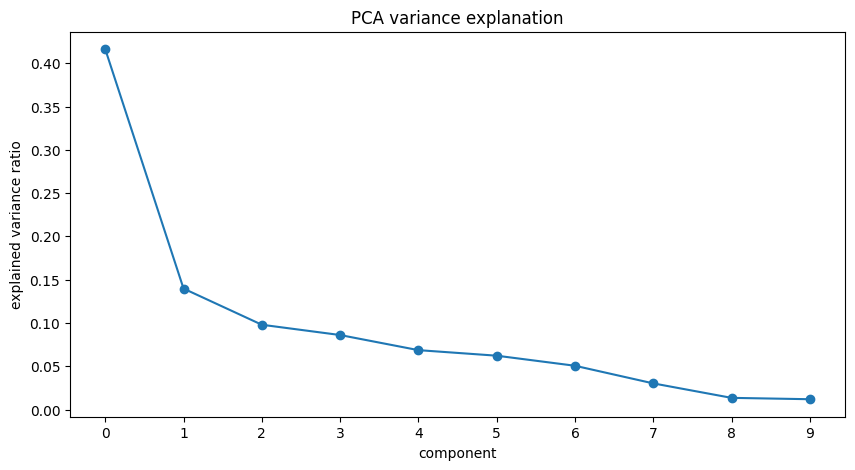

In [24]:
n_components = 10
pca = PCA(n_components=n_components)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

plt.figure(figsize=(10, 5))
plt.plot(range(n_components), pca.explained_variance_ratio_, marker='o')
plt.xlabel('component')
plt.ylabel('explained variance ratio')
plt.xticks(range(n_components))
plt.title('PCA variance explanation')
plt.show()

# Export data to csv

In [26]:
pd.concat([X_train, y_train], axis=1).to_csv('train_dataset1.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('test_dataset1.csv', index=False)